# Imports

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
from tensorflow import keras
from tensorflow.keras import layers
import shap

# Download dataset

In [ ]:
import pathlib

dir_base = '/home/'
dataset_url = "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/wtp4ssmwsd-1.zip"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname= dir_base + 'traffic_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
import zipfile
with zipfile.ZipFile(dir_base + 'traffic_photos.tar.gz', 'r') as zip_ref:
    zip_ref.extractall(dir_base)
with zipfile.ZipFile(dir_base + 'obj.zip', 'r') as zip_ref:
    zip_ref.extractall(dir_base)

dir_img = dir_base + 'obj/' 

# Read classification

In [ ]:
from os import listdir
from os.path import isfile, join
onlyfilestxt = [f for f in listdir(dir_img) if isfile(join(dir_img, f)) and f.endswith('.txt')]

In [ ]:
len(onlyfilestxt)

4234

In [ ]:
dir_img_only = dir_img + 'images/'
if not os.path.exists(dir_img_only):
    os.mkdir(dir_img_only)
    os.mkdir(dir_img_only + 'traffic/')
    os.mkdir(dir_img_only + 'no_traffic/')


In [ ]:
for filename in onlyfilestxt:
  with open(dir_img + filename) as f:
    lines = f.readlines()
    img_filename = filename[:-4] + '.jpg'

    if len(lines)>0 and len(lines[0])>0:
      # Traffic
      if lines[0][0] == '0':
        os.rename(dir_img + img_filename, dir_img_only + 'traffic/' + img_filename)
      # No traffic
      else:
        os.rename(dir_img + img_filename, dir_img_only + 'no_traffic/' + img_filename)

  os.remove(dir_img + filename)

In [ ]:
onlyfiles_no_traffic = [f for f in listdir(dir_img_only + 'no_traffic/') if isfile(join(dir_img_only + 'no_traffic/', f))]
onlyfiles_traffic = [f for f in listdir(dir_img_only + 'traffic/') if isfile(join(dir_img_only + 'traffic/', f))]

print(len(onlyfiles_no_traffic))
print(len(onlyfiles_traffic))

2063
2169


# Read images
https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

# Data augmentation
datagen = ImageDataGenerator(rescale=(1/255)#,
    #rotation_range=40,  #Rota imagenes aleatoriamente en un rango de 40º [-40 - 40]
    #width_shift_range=0.2,  #Desplaza imagenes aleatoriamente
    #height_shift_range=0.2, #Desplaza imagenes aleatoriamente
    #shear_range=0.2,  #Recorta imagenes aleatoriamente
    #zoom_range=0.2, #Zoom en imagenes aleatoriamente
    #horizontal_flip=True,
    #fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
  dir_img_only,
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  #batch_size=BATCH_SIZE,
  batch_size=-1, #Falta comprobar
  #subset='training',
  shuffle = False,
  class_mode = 'binary',
  classes = ['no_traffic','traffic']
)

Found 4232 images belonging to 2 classes.


# Show images

In [ ]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(25, 2))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,:])
        plt.gray()
        ax.set_title(f'{y[index[i]]}-{index[i]}')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def plot_image(X,y,index=0):
    plt.figure(figsize=(25, 2))
    ax = plt.subplot(1,1,1)
    plt.imshow(X[index])
    plt.gray()
    ax.set_title(f'{y[index]}-{index}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

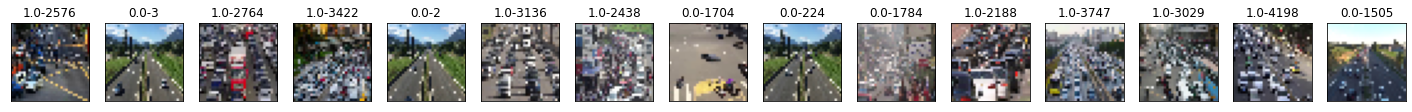

In [ ]:
X,y = train_generator.next()
plot_symbols(X, y, 15)

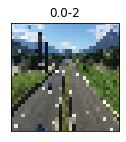

In [ ]:
plot_image(X,y,2)

# Data augmentation

In [ ]:
def data_augmentation(X_train,y_train,batch_size):
  image_gen=ImageDataGenerator(
    rotation_range=40,  #Rota imagenes aleatoriamente en un rango de 40º [-40 - 40]
    width_shift_range=0.2,  #Desplaza imagenes aleatoriamente
    height_shift_range=0.2, #Desplaza imagenes aleatoriamente
    shear_range=0.2,  #Recorta imagenes aleatoriamente
    zoom_range=0.2, #Zoom en imagenes aleatoriamente
    horizontal_flip=True,
    fill_mode='nearest')

  data_augmented=image_gen.flow(X_train, y_train, batch_size=batch_size,seed=1)

  return data_augmented

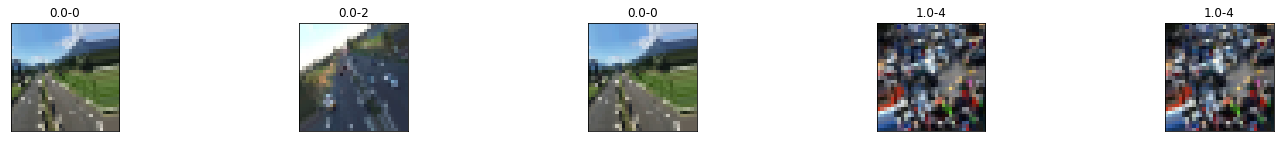

In [ ]:
it = data_augmentation(X,y,5)
batch = it.next()

plot_symbols(batch[0], batch[1], 5)

# Split data

In [ ]:
n_cross_val = 10
skf=sklearn.model_selection.StratifiedKFold(n_splits=n_cross_val,random_state=1,shuffle=True)


# Models

In [ ]:
import tensorflow_hub as hub

def cnn_model():
  #Descargamos el modelo
  URL = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
  feature_extractor =  hub.KerasLayer(
      URL,
      input_shape=X[0].shape
  )

  #Bloqueamos el entrenamiento de los pesos ya entrenados de esta red
  feature_extractor.trainable=False

  #Adaptamos la red a nuestras necesidades
  model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(1,activation='sigmoid')
  ])

  return model

In [ ]:
def cnn_model2():
  visible = layers.Input(shape=X[0].shape)
  x = layers.Conv2D(16,(3,3),padding="same",activation="relu")(visible)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Flatten()(x)

  x = layers.Dense(512,activation="relu")(x)
  
  x = layers.Dense(256,activation="relu")(x)
  
  x = layers.Dense(64,activation="relu")(x)

  x = layers.Dense(32,activation="relu")(x)

  output = layers.Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs=visible, outputs=output)

  return model

In [ ]:
def cnn_model3():
  visible = layers.Input(shape=X[0].shape)
  x = layers.Conv2D(16,(3,3),padding="same",activation="relu")(visible)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Flatten()(x)

  x = layers.Dense(512,activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  
  x = layers.Dense(256,activation="relu")(x)
  x = layers.Dropout(0.1)(x)
  
  x = layers.Dense(64,activation="relu")(x)
  x = layers.Dropout(0.1)(x)

  x = layers.Dense(32,activation="relu")(x)

  output = layers.Dense(1, activation='sigmoid')(x)

  model = keras.Model(inputs=visible, outputs=output)

  return model

# Training

In [ ]:
epochs = 500

cvscores=[]
y_cvscores=[]
cvy_test=[]
cvy_train=[]
i=0

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

for train_index,test_index in skf.split(X,y):#nuevo
#for train_index,test_index in skf.split(train_generator):#nuevo
  print(f'Folder: {i}')
  i+=1
  model = cnn_model2()

  X_train,X_test=X[train_index],X[test_index]#nuevo Falta cambiar
  y_train_nn,y_test_nn=y[train_index],y[test_index]#nuevo Falta cambiar
  y_train,y_test=y[train_index],y[test_index] #Falta cambiar

  data_augmented=data_augmentation(X_train,y_train_nn,32) #Aumentado de datos

  cvy_test.append(y_test)
  cvy_train.append(y_train)

  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  history=model.fit(data_augmented, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(X_test,y_test_nn), verbose=2, callbacks=[early_stopping]) #Aumentado de datos


  scores =model.evaluate(X_test,y_test_nn,verbose=0)
  y_scores=model.predict(X_test) # Confidence prediction per class
  cvscores.append(scores)
  y_cvscores.append(y_scores)
  #print("%s: %.2f%%"%(model.metrics_names[1],scores[1]*100))
  #Borrar:
  #if i==2:
  #  break

print(model.summary())

Folder: 0
Epoch 1/500
119/119 - 3s - loss: 0.3797 - accuracy: 0.8400 - val_loss: 0.3131 - val_accuracy: 0.8986 - 3s/epoch - 23ms/step
Epoch 2/500
119/119 - 2s - loss: 0.2985 - accuracy: 0.8792 - val_loss: 0.2107 - val_accuracy: 0.9222 - 2s/epoch - 17ms/step
Epoch 3/500
119/119 - 2s - loss: 0.2567 - accuracy: 0.8915 - val_loss: 0.2329 - val_accuracy: 0.9198 - 2s/epoch - 16ms/step
Epoch 4/500
119/119 - 2s - loss: 0.2158 - accuracy: 0.9125 - val_loss: 0.4001 - val_accuracy: 0.8892 - 2s/epoch - 17ms/step
Epoch 5/500
119/119 - 2s - loss: 0.2212 - accuracy: 0.9154 - val_loss: 0.2453 - val_accuracy: 0.9151 - 2s/epoch - 17ms/step
Epoch 6/500
119/119 - 2s - loss: 0.2182 - accuracy: 0.9157 - val_loss: 0.2605 - val_accuracy: 0.9316 - 2s/epoch - 17ms/step
Epoch 7/500
119/119 - 2s - loss: 0.1742 - accuracy: 0.9356 - val_loss: 1.7485 - val_accuracy: 0.5283 - 2s/epoch - 17ms/step
Epoch 8/500
119/119 - 2s - loss: 0.1974 - accuracy: 0.9217 - val_loss: 0.2641 - val_accuracy: 0.9269 - 2s/epoch - 17ms/ste

In [ ]:

cv_loss = []
cv_acc = []
loss=0
acc=0
for i in range(len(cvscores)):
  i_loss, i_acc = cvscores[i]
  cv_loss.append(i_loss)
  cv_acc.append(i_acc)
  
  loss+=i_loss
  acc+=i_acc
loss/=len(cvscores)
acc/=len(cvscores)
acc0=cv_acc
print(f'loss: {loss:.2f} acc: {acc:.2f}')

loss: 0.14 acc: 0.96


##Evaluación overfitting

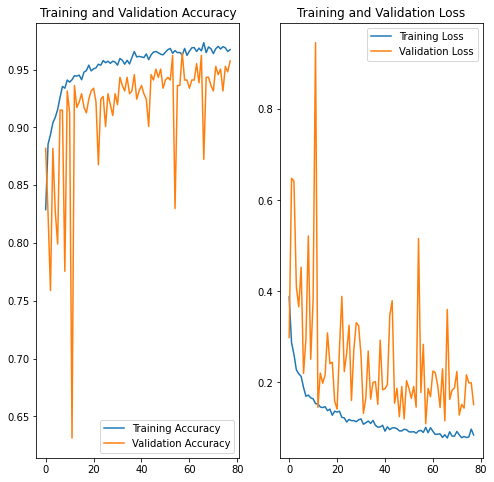

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('./foo.png')
plt.show()

# AUC

In [ ]:
from sklearn import metrics

cv_auc0=[]
auc0=0
#y_cvscores = predicciones
#cvy_test = soluciones

for i in range(len(y_cvscores)):
  y_pred = y_cvscores[i].argmax(axis=1) # Select classes with most confidence prediction
  auc_i=metrics.roc_auc_score(cvy_test[i], np.round(y_cvscores[i][:,0],2))
  auc0+=auc_i

  cv_auc0.append(auc_i)

auc0/=len(cv_auc0)
print(cv_auc0)
print(f'AUC {auc0:.4f} ')

[0.9974398361495136, 0.9876207729468599]
AUC 0.9925 


# SHAP

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


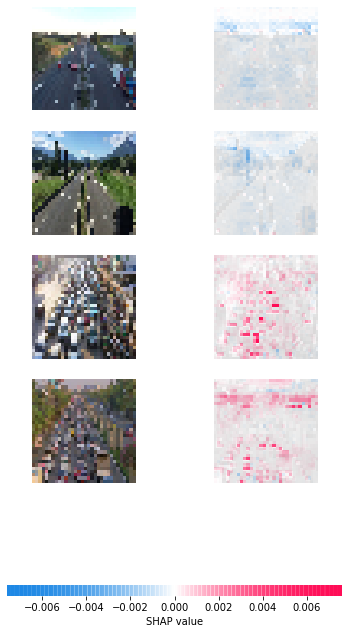

In [ ]:
# select a set of background examples to take an expectation over
background = X[np.random.choice(X.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background[1:5])

# plot the feature attributions
shap.image_plot(shap_values, background[1:5])

# Otro modelo

In [ ]:
epochs = 500

cvscores=[]
y_cvscores=[]
cvy_test=[]
cvy_train=[]
i=0

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

for train_index,test_index in skf.split(X,y):#nuevo
#for train_index,test_index in skf.split(train_generator):#nuevo
  print(f'Folder: {i}')
  i+=1
  model = cnn_model3()

  X_train,X_test=X[train_index],X[test_index]#nuevo Falta cambiar
  y_train_nn,y_test_nn=y[train_index],y[test_index]#nuevo Falta cambiar
  y_train,y_test=y[train_index],y[test_index] #Falta cambiar

  data_augmented=data_augmentation(X_train,y_train_nn,32) #Aumentado de datos

  cvy_test.append(y_test)
  cvy_train.append(y_train)

  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  history=model.fit(data_augmented, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(X_test,y_test_nn), verbose=2, callbacks=[early_stopping]) #Aumentado de datos


  scores =model.evaluate(X_test,y_test_nn,verbose=0)
  y_scores=model.predict(X_test) # Confidence prediction per class
  cvscores.append(scores)
  y_cvscores.append(y_scores)
  #print("%s: %.2f%%"%(model.metrics_names[1],scores[1]*100))
  #Borrar:
  #if i==2:
  #  break

print(model.summary())

Folder: 0
Epoch 1/500
119/119 - 3s - loss: 0.4022 - accuracy: 0.8269 - val_loss: 0.2548 - val_accuracy: 0.9033 - 3s/epoch - 25ms/step
Epoch 2/500
119/119 - 2s - loss: 0.3184 - accuracy: 0.8723 - val_loss: 0.2810 - val_accuracy: 0.8939 - 2s/epoch - 17ms/step
Epoch 3/500
119/119 - 2s - loss: 0.2969 - accuracy: 0.8834 - val_loss: 0.4024 - val_accuracy: 0.8774 - 2s/epoch - 17ms/step
Epoch 4/500
119/119 - 2s - loss: 0.2772 - accuracy: 0.8860 - val_loss: 0.7522 - val_accuracy: 0.7052 - 2s/epoch - 17ms/step
Epoch 5/500
119/119 - 2s - loss: 0.2560 - accuracy: 0.8976 - val_loss: 0.2761 - val_accuracy: 0.9033 - 2s/epoch - 16ms/step
Epoch 6/500
119/119 - 2s - loss: 0.2230 - accuracy: 0.9131 - val_loss: 0.5273 - val_accuracy: 0.7406 - 2s/epoch - 17ms/step
Epoch 7/500
119/119 - 2s - loss: 0.1928 - accuracy: 0.9254 - val_loss: 0.7672 - val_accuracy: 0.6910 - 2s/epoch - 16ms/step
Epoch 8/500
119/119 - 2s - loss: 0.1933 - accuracy: 0.9259 - val_loss: 0.3639 - val_accuracy: 0.8255 - 2s/epoch - 17ms/ste

In [ ]:
cv_auc1=[]
auc1=0
#y_cvscores = predicciones
#cvy_test = soluciones

for i in range(len(y_cvscores)):
  y_pred = y_cvscores[i].argmax(axis=1) # Select classes with most confidence prediction
  auc_i=metrics.roc_auc_score(cvy_test[i], np.round(y_cvscores[i][:,0],2))
  auc1+=auc_i

  cv_auc1.append(auc_i)

auc1/=len(cv_auc1)
print(cv_auc1)
print(f'AUC {auc1:.4f} ')

[0.9971949509116409, 0.9901145106459115, 0.9898125782787619, 0.9934007426960763, 0.9911860766856069, 0.9975057044427542, 0.9895865956780457, 0.9905485213189567, 0.9914321506867703, 0.9901346695897275]
AUC 0.9921 


# Comparación Wilcoxon

[0.9974398361495136, 0.9876207729468599]
[0.9971949509116409, 0.9901145106459115, 0.9898125782787619, 0.9934007426960763, 0.9911860766856069, 0.9975057044427542, 0.9895865956780457, 0.9905485213189567, 0.9914321506867703, 0.9901346695897275]


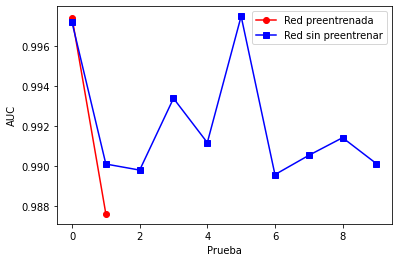

In [ ]:
print(cv_auc0)
print(cv_auc1)
plt.plot(range(len(cv_auc0)),cv_auc0,'ro-',label='Red preentrenada')
plt.plot(range(len(cv_auc1)),cv_auc1,'bs-',label='Red sin preentrenar')
plt.ylabel('AUC')
plt.xlabel('Prueba')
plt.legend()

In [ ]:
epochs = 500

cvscores=[]
y_cvscores=[]
cvy_test=[]
cvy_train=[]
i=0

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

for train_index,test_index in skf.split(X,y):#nuevo
#for train_index,test_index in skf.split(train_generator):#nuevo
  print(f'Folder: {i}')
  i+=1
  model = cnn_model()

  X_train,X_test=X[train_index],X[test_index]#nuevo Falta cambiar
  y_train_nn,y_test_nn=y[train_index],y[test_index]#nuevo Falta cambiar
  y_train,y_test=y[train_index],y[test_index] #Falta cambiar

  data_augmented=data_augmentation(X_train,y_train_nn,32) #Aumentado de datos

  cvy_test.append(y_test)
  cvy_train.append(y_train)

  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  history=model.fit(data_augmented, batch_size=BATCH_SIZE, epochs=epochs, validation_data=(X_test,y_test_nn), verbose=2, callbacks=[early_stopping]) #Aumentado de datos


  scores =model.evaluate(X_test,y_test_nn,verbose=0)
  y_scores=model.predict(X_test) # Confidence prediction per class
  cvscores.append(scores)
  y_cvscores.append(y_scores)
  #print("%s: %.2f%%"%(model.metrics_names[1],scores[1]*100))
  #Borrar:
  #if i==2:
  #  break

print(model.summary())

Folder: 0
Epoch 1/500
119/119 - 9s - loss: 0.4919 - accuracy: 0.8017 - val_loss: 0.3654 - val_accuracy: 0.8656 - 9s/epoch - 72ms/step
Epoch 2/500
119/119 - 3s - loss: 0.4144 - accuracy: 0.8382 - val_loss: 0.3236 - val_accuracy: 0.8679 - 3s/epoch - 21ms/step
Epoch 3/500
119/119 - 3s - loss: 0.3835 - accuracy: 0.8416 - val_loss: 0.3012 - val_accuracy: 0.8774 - 3s/epoch - 21ms/step
Epoch 4/500
119/119 - 3s - loss: 0.3577 - accuracy: 0.8637 - val_loss: 0.2904 - val_accuracy: 0.8844 - 3s/epoch - 22ms/step
Epoch 5/500
119/119 - 3s - loss: 0.3615 - accuracy: 0.8526 - val_loss: 0.2807 - val_accuracy: 0.8844 - 3s/epoch - 21ms/step
Epoch 6/500
119/119 - 3s - loss: 0.3509 - accuracy: 0.8537 - val_loss: 0.2739 - val_accuracy: 0.8844 - 3s/epoch - 21ms/step
Epoch 7/500
119/119 - 3s - loss: 0.3402 - accuracy: 0.8645 - val_loss: 0.2693 - val_accuracy: 0.8868 - 3s/epoch - 21ms/step
Epoch 8/500
119/119 - 3s - loss: 0.3294 - accuracy: 0.8639 - val_loss: 0.2672 - val_accuracy: 0.8915 - 3s/epoch - 21ms/ste

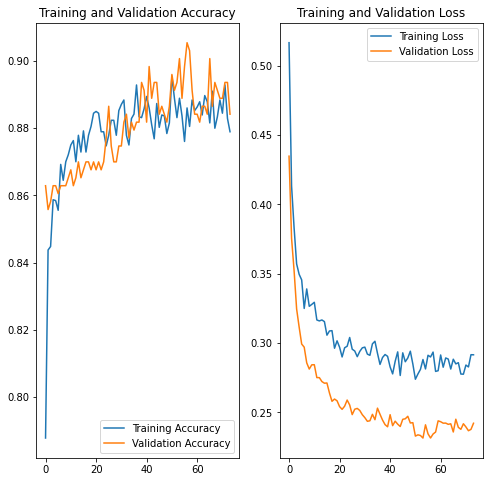

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig('./foo.png')
plt.show()

In [ ]:
cv_auc3=[]
auc3=0
#y_cvscores = predicciones
#cvy_test = soluciones

for i in range(len(y_cvscores)):
  y_pred = y_cvscores[i].argmax(axis=1) # Select classes with most confidence prediction
  auc_i=metrics.roc_auc_score(cvy_test[i], np.round(y_cvscores[i][:,0],2))
  auc3+=auc_i

  cv_auc3.append(auc_i)

auc3/=len(cv_auc3)
print(cv_auc3)
print(f'AUC {auc3:.4f} ')

[0.9640352634742537, 0.950807389515119, 0.9681629092860976, 0.9699342311305982, 0.9649120844704934, 0.9677978613932263, 0.9536374211444677, 0.9632678627354481, 0.9700572681311799, 0.9640731958301642]
AUC 0.9637 


[0.9974398361495136, 0.9876207729468599]
[0.9640352634742537, 0.950807389515119, 0.9681629092860976, 0.9699342311305982, 0.9649120844704934, 0.9677978613932263, 0.9536374211444677, 0.9632678627354481, 0.9700572681311799, 0.9640731958301642]


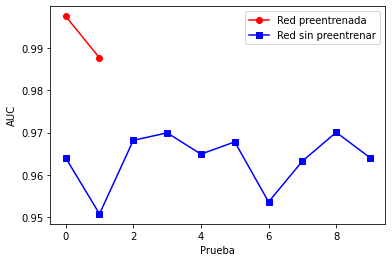

In [ ]:
print(cv_auc0)
print(cv_auc3)
plt.plot(range(len(cv_auc0)),cv_auc0,'ro-',label='Red preentrenada')
plt.plot(range(len(cv_auc3)),cv_auc3,'bs-',label='Red sin preentrenar')
plt.ylabel('AUC')
plt.xlabel('Prueba')
plt.legend()